In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 591ms/step - loss: 0.0622
Average validation loss: 0.4898231625556946
4/4 [==============================] - 6s 609ms/step - loss: 0.0622 - val_loss: 0.4898
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 605ms/step - loss: 0.0459 - val_loss: 0.4898
Average validation loss: 0.4447503685951233
4/4 [==============================] - 8s 619ms/step - loss: 0.0459 - val_loss: 0.4673
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 600ms/step - loss: 0.0362 - val_loss: 0.4673
Average validation loss: 0.5483651161193848
4/4 [==============================] - 11s 615ms/step - loss: 0.0362 - val_loss: 0.4943
Epoch 4/10
4/4 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 713ms/step - loss: 0.0032
Average validation loss: 0.00030941428849473596
8/8 [==============================] - 6s 726ms/step - loss: 0.0032 - val_loss: 3.0941e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 752ms/step - loss: 0.0032 - val_loss: 3.0941e-04
Average validation loss: 9.47667366801852e-08
8/8 [==============================] - 12s 764ms/step - loss: 0.0032 - val_loss: 1.5475e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 777ms/step - loss: 0.0032 - val_loss: 1.5475e-04
Average validation loss: 3.670989023873972e-08
8/8 [==============================] - 18s 790ms/step - loss: 0.0032 - val_loss: 1.0318e-04
Saved mode

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 721ms/step - loss: 0.0037
Average validation loss: 0.18724748492240906
12/12 [==============================] - 9s 733ms/step - loss: 0.0037 - val_loss: 0.1872
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 759ms/step - loss: 0.0036 - val_loss: 0.1872
Average validation loss: 0.0705946132641581
12/12 [==============================] - 18s 771ms/step - loss: 0.0036 - val_loss: 0.1289
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 716ms/step - loss: 0.0036 - val_loss: 0.1289
Average validation loss: 0.06534506345997215
12/12 [==============================] - 27s 732ms/step - loss: 0.0036 - val_loss: 0.1077
Saved model weights to 'c

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 730ms/step - loss: 0.0030
Average validation loss: 0.118494060579025
16/16 [==============================] - 12s 745ms/step - loss: 0.0030 - val_loss: 0.1185
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 722ms/step - loss: 0.0029 - val_loss: 0.1185
Average validation loss: 0.058698313704553584
16/16 [==============================] - 24s 734ms/step - loss: 0.0029 - val_loss: 0.0886
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 738ms/step - loss: 0.0027 - val_loss: 0.0886
Average validation loss: 0.022234561648474482
16/16 [==============================] - 36s 752ms/step - loss: 0.0027 - val_loss: 0.0665
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 746ms/step - loss: 0.0021
Average validation loss: 0.024199043547923793
20/20 [==============================] - 15s 759ms/step - loss: 0.0021 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 740ms/step - loss: 0.0020 - val_loss: 0.0242
Average validation loss: 0.04601762548554689
20/20 [==============================] - 30s 752ms/step - loss: 0.0020 - val_loss: 0.0351
Epoch 3/10
20/20 [==============================] - 45s 723ms/step - loss: 0.0020 - val_loss: 0.0351
Average validation loss: 0.030597963242325932
20/20 [==============================] - 45s 733ms/step - loss: 0.0020 - val_loss: 0.0336
Epoch 4/10
20/20 [==============================] - 59s 726ms/step - loss: 0.0020 - val_loss: 0.0336
Average validation loss: 0.023364692088216545
20/20 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 725ms/step - loss: 0.0023
Average validation loss: 0.19652031610409418
24/24 [==============================] - 18s 738ms/step - loss: 0.0023 - val_loss: 0.1965
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 36s 737ms/step - loss: 0.0021 - val_loss: 0.1965
Average validation loss: 0.024945156027873356
24/24 [==============================] - 36s 751ms/step - loss: 0.0021 - val_loss: 0.1107
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 54s 743ms/step - loss: 0.0020 - val_loss: 0.1107
Average validation loss: 0.028049591307838757
24/24 [==============================] - 54s 757ms/step - loss: 0.0020 - val_loss: 0.0832
Epoch 4/10
24/24 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 724ms/step - loss: 0.0028
Average validation loss: 0.04384196735918522
40/40 [==============================] - 30s 736ms/step - loss: 0.0028 - val_loss: 0.0438
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 714ms/step - loss: 0.0026 - val_loss: 0.0438
Average validation loss: 0.03819368351250887
40/40 [==============================] - 59s 727ms/step - loss: 0.0026 - val_loss: 0.0410
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 728ms/step - loss: 0.0025 - val_loss: 0.0410
Average validation loss: 0.06076917722821236
40/40 [==============================] - 88s 740ms/step - loss: 0.0025 - val_loss: 0.0476
Epoch 4/10
40/40 [====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 36s 743ms/step - loss: 0.0021
Average validation loss: 0.02647217438455603
48/48 [==============================] - 36s 756ms/step - loss: 0.0021 - val_loss: 0.0265
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 730ms/step - loss: 0.0019 - val_loss: 0.0265
Average validation loss: 0.023336777041549794
48/48 [==============================] - 72s 742ms/step - loss: 0.0019 - val_loss: 0.0249
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 108s 739ms/step - loss: 0.0018 - val_loss: 0.0249
Average validation loss: 0.016462893690913916
48/48 [==============================] - 108s 752ms/step - loss: 0.0018 - val_loss: 0.0221
Saved model weight

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 737ms/step - loss: 0.0021
Average validation loss: 0.04732719866296975
56/56 [==============================] - 42s 749ms/step - loss: 0.0021 - val_loss: 0.0473
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 84s 739ms/step - loss: 0.0019 - val_loss: 0.0473
Average validation loss: 0.02117873532032328
56/56 [==============================] - 84s 752ms/step - loss: 0.0019 - val_loss: 0.0343
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 125s 735ms/step - loss: 0.0017 - val_loss: 0.0343
Average validation loss: 0.02461651862904546
56/56 [==============================] - 126s 748ms/step - loss: 0.0017 - val_loss: 0.0310
Epoch 4/10
56/56 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 733ms/step - loss: 0.0015
Average validation loss: 0.012950046511832625
64/64 [==============================] - 48s 746ms/step - loss: 0.0015 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 735ms/step - loss: 0.0013 - val_loss: 0.0130
Average validation loss: 0.012214154332468752
64/64 [==============================] - 96s 747ms/step - loss: 0.0013 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 143s 740ms/step - loss: 0.0012 - val_loss: 0.0126
Average validation loss: 0.017367634740367066
64/64 [==============================] - 144s 752ms/step - loss: 0.0012 - val_loss: 0.0142
Epoch 4/10
64/64 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 736ms/step - loss: 0.0014
Average validation loss: 0.021106533602707915
72/72 [==============================] - 54s 748ms/step - loss: 0.0014 - val_loss: 0.0211
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 107s 732ms/step - loss: 0.0012 - val_loss: 0.0211
Average validation loss: 0.011688530755539736
72/72 [==============================] - 107s 744ms/step - loss: 0.0012 - val_loss: 0.0164
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 160s 734ms/step - loss: 0.0011 - val_loss: 0.0164
Average validation loss: 0.011435333975694247
72/72 [==============================] - 161s 747ms/step - loss: 0.0011 - val_loss: 0.0147
Saved model wei

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 59s 736ms/step - loss: 0.0012
Average validation loss: 0.01116638045059517
80/80 [==============================] - 60s 749ms/step - loss: 0.0012 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 118s 729ms/step - loss: 0.0011 - val_loss: 0.0112
Average validation loss: 0.008540498930960894
80/80 [==============================] - 119s 742ms/step - loss: 0.0011 - val_loss: 0.0099
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 178s 732ms/step - loss: 0.0010 - val_loss: 0.0099
Average validation loss: 0.00632042814977467
80/80 [==============================] - 179s 745ms/step - loss: 0.0010 - val_loss: 0.0087
Saved model wei

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 731ms/step - loss: 0.0021
Average validation loss: 0.016452769398407934
96/96 [==============================] - 71s 743ms/step - loss: 0.0021 - val_loss: 0.0165
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 141s 729ms/step - loss: 0.0016 - val_loss: 0.0165
Average validation loss: 0.037038924380605444
96/96 [==============================] - 143s 742ms/step - loss: 0.0016 - val_loss: 0.0267
Epoch 3/10
96/96 [==============================] - 212s 721ms/step - loss: 0.0013 - val_loss: 0.0267
Average validation loss: 0.09831523232321142
96/96 [==============================] - 213s 734ms/step - loss: 0.0013 - val_loss: 0.0506
Epoch 4/10
96/96 [==============================] - 282s 718ms/step - loss: 0.0012 - val_loss: 0.0506
Average validation loss: 0.024360973426761728
96/96 [==========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 720ms/step - loss: 0.0014
Average validation loss: 0.019541751282910507
120/120 [==============================] - 88s 733ms/step - loss: 0.0014 - val_loss: 0.0195
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 723ms/step - loss: 0.0011 - val_loss: 0.0195
Average validation loss: 0.012153008906170725
120/120 [==============================] - 176s 736ms/step - loss: 0.0011 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 263s 720ms/step - loss: 0.0010 - val_loss: 0.0158
Average validation loss: 0.01151830389474829
120/120 [==============================] - 264s 733ms/step - loss: 0.0010 - val_loss: 0.0144
Sa

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 0.0012
Average validation loss: 0.013030583310561875
144/144 [==============================] - 105s 733ms/step - loss: 0.0012 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 721ms/step - loss: 0.0010 - val_loss: 0.0130
Average validation loss: 0.017687650627825253
144/144 [==============================] - 211s 733ms/step - loss: 0.0010 - val_loss: 0.0154
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 9.1819e-04 - val_loss: 0.0154
Average validation loss: 0.011128733490800692
144/144 [==============================] - 317s 732ms/step - loss: 9.1819e-04 - val_loss: 0.0139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 720ms/step - loss: 8.3609e-04
Average validation loss: 0.00627231702383142
160/160 [==============================] - 117s 732ms/step - loss: 8.3609e-04 - val_loss: 0.0063
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 233s 725ms/step - loss: 6.8988e-04 - val_loss: 0.0063
Average validation loss: 0.04518675898319202
160/160 [==============================] - 235s 737ms/step - loss: 6.8988e-04 - val_loss: 0.0257
Epoch 3/10
160/160 [==============================] - 351s 724ms/step - loss: 6.3794e-04 - val_loss: 0.0257
Average validation loss: 0.005500706110615284
160/160 [==============================] - 353s 736ms/step - loss: 6.3794e-04 - val_loss: 0.0190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segform

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0015
Average validation loss: 0.012993808933533729
200/200 [==============================] - 147s 733ms/step - loss: 0.0015 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 722ms/step - loss: 0.0013 - val_loss: 0.0130
Average validation loss: 0.01274900110438466
200/200 [==============================] - 293s 734ms/step - loss: 0.0013 - val_loss: 0.0129
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 438s 723ms/step - loss: 0.0012 - val_loss: 0.0129
Average validation loss: 0.011480529210530221
200/200 [==============================] - 441s 735ms/step - loss: 0.0012 - val_loss: 0.0124


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:11 - loss: 2.6698e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 725ms/step - loss: 9.4082e-04
Average validation loss: 0.010154546611981155
240/240 [==============================] - 177s 737ms/step - loss: 9.4082e-04 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 351s 725ms/step - loss: 8.3924e-04 - val_loss: 0.0102
Average validation loss: 0.00889199678664833
240/240 [==============================] - 354s 737ms/step - loss: 8.3924e-04 - val_loss: 0.0095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 527s 720ms/step - loss: 7.5169e-04 - val_loss: 0.0095
Average validation loss: 0.010754091467849019
240/240 [==============================] - 530s 732ms/step - loss: 7.5169

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11557492414120678, 0.07465527104923403, 0.10067293171839323, 0.06582163626452556, 0.03922575572710567, 0.04526773428344199, 0.04198786185372414, 0.04061079196307468, 0.018461070466581436, 0.028647696965053343, 0.0190058262246535, 0.013675949654986657, 0.014859897708235412, 0.0070005903468879, 0.00839091115474629, 0.006103424424293394, 0.008347457696741913, 0.006278685385210352]
std_val_losses =  [0.17747854968333807, 0.07283388924273942, 0.07881715373344164, 0.07065154948838724, 0.03519922667151232, 0.04146609248647166, 0.03675985025825052, 0.08511932910426029, 0.01370489777792029, 0.071849884980447, 0.03554103622319335, 0.022793806167115366, 0.01635813041208299, 0.003499819478486128, 0.006367321404007441, 0.006814567347919351, 0.00835431701742481, 0.002805561749724669]


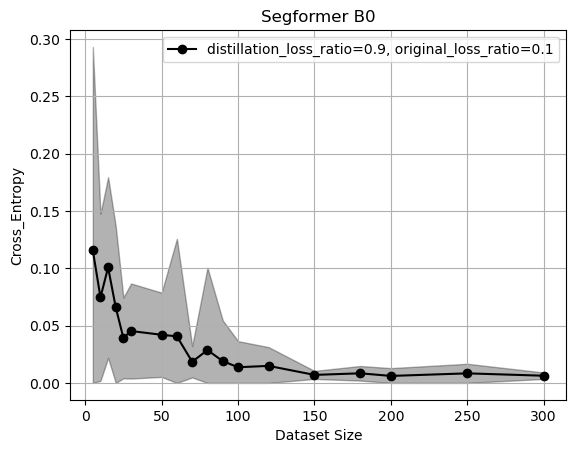

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()